# **Car Body Damage Detection**
### -Detect scratch, dent, repaint etc. on car body

### Source/Useful Links

For Segmentation: https://www.tensorflow.org/tutorials/images/segmentation

U-net - https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

Data Preprocessing:
1. https://towardsdatascience.com/cnn-application-detecting-car-exterior-damage-full-implementable-code-1b205e3cb48c

2. https://www.analyticsvidhya.com/blog/2018/07/building-mask-r-cnn-model-detecting-damage-cars-python/

Training and predictions: 
Google Colab https://colab.research.google.com/

In [0]:
# Using segmentation_models for image segmentation task, https://github.com/qubvel/segmentation_models
! pip install segmentation-models

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import datetime
import IPython.display as display
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import pathlib
from PIL import Image
import numpy as np
#from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
from datetime import datetime
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

from IPython.display import clear_output
import matplotlib.pyplot as plt
AUTOTUNE = tf.data.experimental.AUTOTUNE
from sklearn.model_selection import train_test_split

# for TensorBoard
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x

import segmentation_models
print(segmentation_models.__version__)

import segmentation_models as sm

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/My Drive/Colab Notebooks/CS2/references/")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join("/content/mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

1.0.1


In [118]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 4. **Data preparation**

In [0]:
def display1(display_list):
  plt.figure(figsize=(8, 8))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [0]:
def create_mask(pred_mask):
  '''
  as predicted mask has 4dim with bacth size we need to remove that
  tf.argmax Returns the index with the largest value across axes of a tensor.
  '''
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [0]:
def show_predictions(dataset=None, num=3):
  '''
  Takes input image and predicts mask and plots the Input, True, Predicted images
  '''
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display1([image[0], mask[0], create_mask(pred_mask)])
  else:
    display1([sample_image, sample_mask,
             model.predict(sample_image[tf.newaxis, ...])[0]])

In [0]:
TRAIN_LENGTH = 49
BATCH_SIZE = 8
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
OUTPUT_CHANNELS = 3

In [141]:
data_root = pathlib.Path("/content/drive/My Drive/Colab Notebooks/CS2/references/new")
val_data_root = pathlib.Path("/content/drive/My Drive/Colab Notebooks/CS2/references/new")
print(val_data_root)

/content/drive/My Drive/Colab Notebooks/CS2/references/new


In [142]:
##Getting all image paths
import random

all_image_paths = list(data_root.glob('images/*/*'))
all_image_paths = [str(path) for path in all_image_paths]

all_mask_paths = list(data_root.glob('masks/*/*'))
all_mask_paths = [str(path) for path in all_mask_paths]

val_all_image_paths = list(data_root.glob('v_images/*/*'))
val_all_image_paths = [str(path) for path in val_all_image_paths]

val_all_mask_paths = list(data_root.glob('v_masks/*/*'))
val_all_mask_paths = [str(path) for path in val_all_mask_paths]

# ##shuffling the images 
# random.shuffle(all_image_paths)

print("image_count = ", len(all_image_paths), ", mask_count = ", len(all_mask_paths))
print("val_image_count = ", len(val_all_image_paths), ", val_mask_count = ", len(val_all_mask_paths))

image_count =  43 , mask_count =  43
val_image_count =  5 , val_mask_count =  5


### Tfdata Generator

In [0]:
def tfdata_generator(images, mask, is_training, batch_size=1):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename, mask):
        #reading path 
        image_string = tf.io.read_file(filename)
        mask_string = tf.io.read_file(mask)
        
        #decoding image
        image = tf.image.decode_jpeg(image_string, channels=3)
        mask = tf.image.decode_jpeg(mask_string, channels=3)

        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        
        #resize the image
        image = tf.image.resize(image, [256, 256])
        mask = tf.image.resize(mask, [256, 256])
        
        image = tf.image.resize_with_crop_or_pad(image, 300, 300) # Add 6 pixels of padding
        image = tf.image.random_crop(image, size=[256, 256, 3], seed = 1) # Random crop back to 256X256
        #image = tf.image.random_brightness(image, max_delta=0.5, seed = 1)
        image = tf.image.random_flip_left_right(image, seed=1)
        image = tf.image.random_flip_up_down(image, seed=1)
        #image = tf.image.random_jpeg_quality(image, 90, 100, seed=1)

        mask = tf.image.resize_with_crop_or_pad(mask, 300, 300) # Add 6 pixels of padding
        mask = tf.image.random_crop(mask, size=[256, 256, 3], seed = 1) # Random crop back to 256X256
        #mask = tf.image.random_brightness(mask, max_delta=0.5, seed = 1)
        mask = tf.image.random_flip_left_right(mask, seed=1)
        mask = tf.image.random_flip_up_down(mask, seed=1)
        #mask = tf.image.random_jpeg_quality(mask, 90, 100, seed=1)

        #image, mask = normalize(image, mask)
        return image, mask
    
    ##creating a dataset from tensorslices
    dataset = tf.data.Dataset.from_tensor_slices((images, mask))
    
    if is_training:
        dataset = dataset.shuffle(100)  # depends on sample size

    # Transform and batch data at the same time
    dataset = dataset.apply(tf.data.experimental.map_and_batch( parse_function, batch_size, num_parallel_batches=32,  # cpu cores
        drop_remainder=True if is_training else False))
    
    #repeat the dataset indefinitely
    dataset = dataset.repeat()

    
    #prefetch the data into CPU/GPU
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset


In [294]:
#creating a generator
tf_image_generator = tfdata_generator(all_image_paths, all_mask_paths, is_training=True, batch_size=8)
val_tf_image_generator = tfdata_generator(val_all_image_paths, val_all_mask_paths, is_training=True, batch_size=4)
tf_image_generator

<PrefetchDataset shapes: ((8, 256, 256, 3), (8, 256, 256, 3)), types: (tf.float32, tf.float32)>

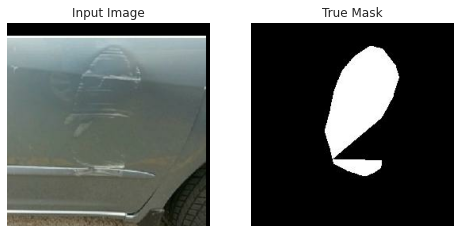

In [296]:
for image, mask in val_tf_image_generator.take(5):
  sample_image, sample_mask = image[0], mask[0]
display1([sample_image, sample_mask])

## 5. Define Custom model

<img src="images/U_net.PNG">

In [0]:
#https://jinglescode.github.io/datascience/2019/12/02/biomedical-image-segmentation-u-net-nested/
#Unet model

class conv_block_nested(tf.keras.Model):

    def __init__(self, in_ch):
        super(conv_block_nested, self).__init__()
        self.activation = layers.Activation('relu')
        self.conv1 = layers.Conv2D(in_ch, 3, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(in_ch, 3, padding='same')
        self.bn2 = layers.BatchNormalization()

    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)

        return output

class Nested_UNet(tf.keras.Model):

    def __init__(self, out_ch=3):
        super(Nested_UNet, self).__init__()

        n1 = 32
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = layers.MaxPooling2D(3, strides=2, padding='same') #2 or 3 ?
        self.Up = layers.UpSampling2D(2)

        self.conv0_0 = conv_block_nested(filters[0])
        self.conv1_0 = conv_block_nested(filters[0])
        self.conv2_0 = conv_block_nested(filters[1])
        self.conv3_0 = conv_block_nested(filters[2])
        self.conv4_0 = conv_block_nested(filters[3])

        self.conv3_1 = conv_block_nested(filters[3])

        self.conv2_2 = conv_block_nested(filters[2])

        self.conv1_3 = conv_block_nested(filters[1])

        self.conv0_4 = conv_block_nested(filters[0])

        self.final = tf.keras.layers.Conv2D(out_ch, 3, activation='sigmoid', padding='same')

    def call(self, x):
        
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        
        x2_0 = self.conv2_0(self.pool(x1_0))
        
        x3_0 = self.conv3_0(self.pool(x2_0))
        
        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(tf.keras.layers.concatenate([x3_0, self.Up(x4_0)]))
        x2_2 = self.conv2_2(tf.keras.layers.concatenate([x2_0, self.Up(x3_1)]))
        x1_3 = self.conv1_3(tf.keras.layers.concatenate([x1_0, self.Up(x2_2)]))
        x0_4 = self.conv0_4(self.Up(x1_3))

        output = self.final(x0_4)
        
        return output

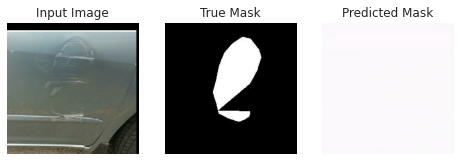

Model: "nested_u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
up_sampling2d (UpSampling2D) multiple                  0         
_________________________________________________________________
conv_block_nested (conv_bloc multiple                  10400     
_________________________________________________________________
conv_block_nested_1 (conv_bl multiple                  18752     
_________________________________________________________________
conv_block_nested_2 (conv_bl multiple                  55936     
_________________________________________________________________
conv_block_nested_3 (conv_bl multiple                  222464    
_________________________________________________________________
conv_block_nested_4 (conv_bl multiple                 

In [297]:
tf.keras.backend.clear_session()
model = Nested_UNet(3)
model.compile()
show_predictions()
model.summary()

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  '''
  To check the predicted mask at each epoch
  '''
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [0]:
# Metrics
# For image segmentation
# COMPETITION METRIC
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate
def dice_coef(y_true, y_pred, smooth=K.epsilon()):
    '''
    This function returns dice coefficient of similarity between y_true and y_pred
    Dice coefficient is also referred to as F1_score, but we will use this name for image segmentation models
    For example, 
    let an instance on y_true and y_pred be [[1,1],[0,1]] and [[1,0],[0,1]]
    this metric first converts the above into [1,1,0,1] abd [1,0,0,1],
    then intersection is calculated as 1*1 + 1*0 + 0*1 + 1*1 = 2 and sum(y_true)+sum(y_pred)= 3+2 = 5
    this returns the value (2.* 2 + 10e-7)/(3 + 2 + 10e-7) ~ 0.8    
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
dependencies = {'dice_coef':dice_coef,
    'dice_loss':sm.losses.dice_loss }

### Compile and fit the model

In [0]:
# https://www.tensorflow.org/tensorboard/r2/scalars_and_keras
logdir = '/content/' + datetime.now().strftime("%Y%m%d-%H%M%S")+'_damage_2020'
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=0,write_images=True)
#train_writer = tf.summary.create_file_writer('./logs/1/train')
# https://keras.io/callbacks/
mc = ModelCheckpoint(filepath = ROOT_DIR +'/car_damage_simple_unet.h5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)
#earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=10)

In [0]:
model = Nested_UNet(OUTPUT_CHANNELS)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=sm.losses.dice_loss, metrics=[dice_coef])

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 0.7074 - dice_coef: 0.2907

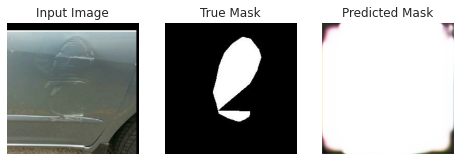


Sample Prediction after epoch 1


Epoch 00001: val_dice_coef improved from -inf to 0.26990, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_simple_unet.h5
49/49 [==============================] - 23s 472ms/step - loss: 0.7074 - dice_coef: 0.2907 - val_loss: 0.7301 - val_dice_coef: 0.2699
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 0.4177 - dice_coef: 0.5820

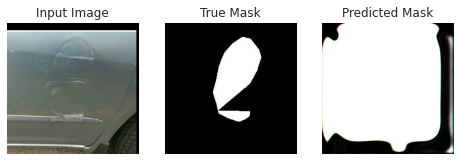


Sample Prediction after epoch 2


Epoch 00002: val_dice_coef improved from 0.26990 to 0.28296, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_simple_unet.h5
49/49 [==============================] - 22s 452ms/step - loss: 0.4177 - dice_coef: 0.5820 - val_loss: 0.7170 - val_dice_coef: 0.2830
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.3276 - dice_coef: 0.6724

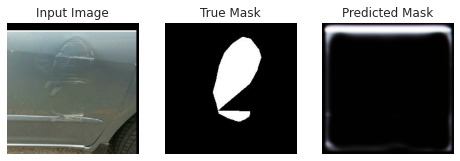


Sample Prediction after epoch 3


Epoch 00003: val_dice_coef improved from 0.28296 to 0.36358, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_simple_unet.h5
49/49 [==============================] - 22s 448ms/step - loss: 0.3276 - dice_coef: 0.6724 - val_loss: 0.6364 - val_dice_coef: 0.3636
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.2685 - dice_coef: 0.7315

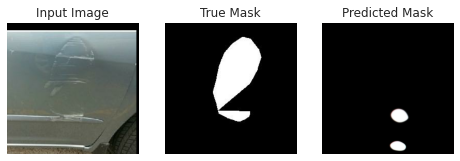


Sample Prediction after epoch 4


Epoch 00004: val_dice_coef improved from 0.36358 to 0.62402, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_simple_unet.h5
49/49 [==============================] - 22s 449ms/step - loss: 0.2685 - dice_coef: 0.7315 - val_loss: 0.3760 - val_dice_coef: 0.6240
Epoch 5/50
49/49 [==============================] - ETA: 0s - loss: 0.2636 - dice_coef: 0.7364

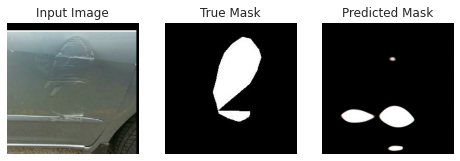


Sample Prediction after epoch 5


Epoch 00005: val_dice_coef did not improve from 0.62402
49/49 [==============================] - 22s 443ms/step - loss: 0.2636 - dice_coef: 0.7364 - val_loss: 0.4126 - val_dice_coef: 0.5874
Epoch 6/50
49/49 [==============================] - ETA: 0s - loss: 0.2459 - dice_coef: 0.7541

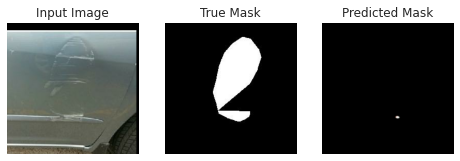


Sample Prediction after epoch 6


Epoch 00006: val_dice_coef did not improve from 0.62402
49/49 [==============================] - 22s 442ms/step - loss: 0.2459 - dice_coef: 0.7541 - val_loss: 0.4209 - val_dice_coef: 0.5791
Epoch 7/50
49/49 [==============================] - ETA: 0s - loss: 0.2463 - dice_coef: 0.7537

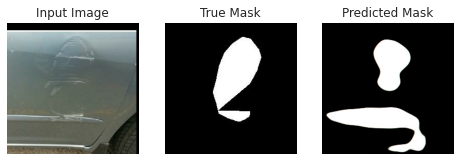


Sample Prediction after epoch 7


Epoch 00007: val_dice_coef did not improve from 0.62402
49/49 [==============================] - 21s 437ms/step - loss: 0.2463 - dice_coef: 0.7537 - val_loss: 0.4015 - val_dice_coef: 0.5985
Epoch 8/50
49/49 [==============================] - ETA: 0s - loss: 0.2052 - dice_coef: 0.7948

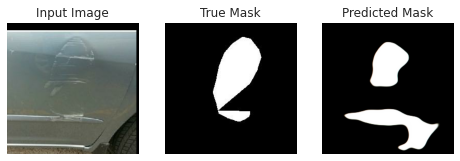


Sample Prediction after epoch 8


Epoch 00008: val_dice_coef did not improve from 0.62402
49/49 [==============================] - 22s 439ms/step - loss: 0.2052 - dice_coef: 0.7948 - val_loss: 0.5425 - val_dice_coef: 0.4575
Epoch 9/50
49/49 [==============================] - ETA: 0s - loss: 0.2059 - dice_coef: 0.7941

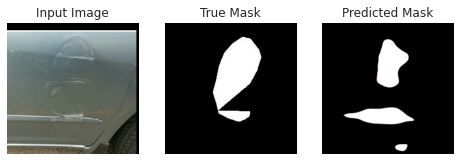


Sample Prediction after epoch 9


Epoch 00009: val_dice_coef did not improve from 0.62402
49/49 [==============================] - 22s 442ms/step - loss: 0.2059 - dice_coef: 0.7941 - val_loss: 0.3850 - val_dice_coef: 0.6150
Epoch 10/50
49/49 [==============================] - ETA: 0s - loss: 0.1920 - dice_coef: 0.8080

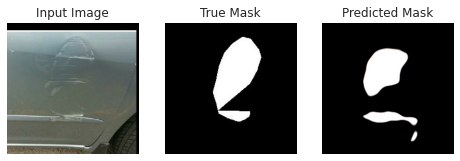


Sample Prediction after epoch 10


Epoch 00010: val_dice_coef did not improve from 0.62402
49/49 [==============================] - 23s 461ms/step - loss: 0.1920 - dice_coef: 0.8080 - val_loss: 0.4489 - val_dice_coef: 0.5511
Epoch 11/50
49/49 [==============================] - ETA: 0s - loss: 0.1726 - dice_coef: 0.8274

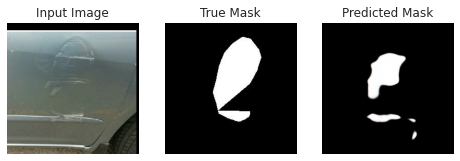


Sample Prediction after epoch 11


Epoch 00011: val_dice_coef improved from 0.62402 to 0.64864, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_simple_unet.h5
49/49 [==============================] - 22s 448ms/step - loss: 0.1726 - dice_coef: 0.8274 - val_loss: 0.3514 - val_dice_coef: 0.6486
Epoch 12/50
49/49 [==============================] - ETA: 0s - loss: 0.1720 - dice_coef: 0.8280

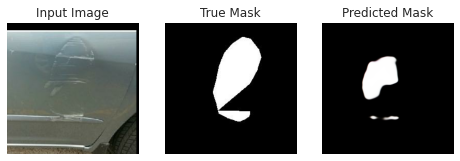


Sample Prediction after epoch 12


Epoch 00012: val_dice_coef improved from 0.64864 to 0.68061, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_simple_unet.h5
49/49 [==============================] - 22s 447ms/step - loss: 0.1720 - dice_coef: 0.8280 - val_loss: 0.3194 - val_dice_coef: 0.6806
Epoch 13/50
49/49 [==============================] - ETA: 0s - loss: 0.1524 - dice_coef: 0.8476

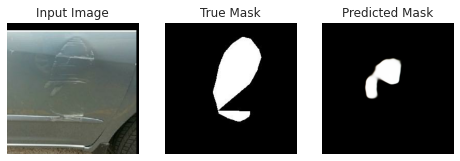


Sample Prediction after epoch 13


Epoch 00013: val_dice_coef did not improve from 0.68061
49/49 [==============================] - 22s 443ms/step - loss: 0.1524 - dice_coef: 0.8476 - val_loss: 0.3404 - val_dice_coef: 0.6596
Epoch 14/50
49/49 [==============================] - ETA: 0s - loss: 0.1490 - dice_coef: 0.8510

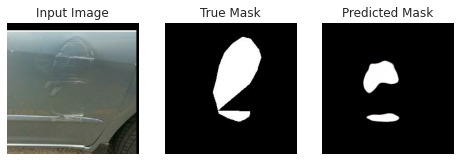


Sample Prediction after epoch 14


Epoch 00014: val_dice_coef did not improve from 0.68061
49/49 [==============================] - 22s 440ms/step - loss: 0.1490 - dice_coef: 0.8510 - val_loss: 0.5265 - val_dice_coef: 0.4735
Epoch 15/50
49/49 [==============================] - ETA: 0s - loss: 0.1573 - dice_coef: 0.8427

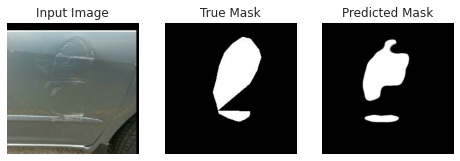


Sample Prediction after epoch 15


Epoch 00015: val_dice_coef did not improve from 0.68061
49/49 [==============================] - 22s 442ms/step - loss: 0.1573 - dice_coef: 0.8427 - val_loss: 0.3658 - val_dice_coef: 0.6342
Epoch 16/50
49/49 [==============================] - ETA: 0s - loss: 0.1431 - dice_coef: 0.8569

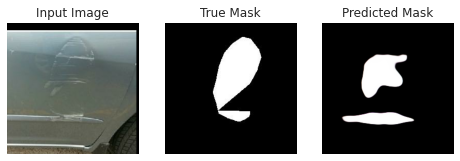


Sample Prediction after epoch 16


Epoch 00016: val_dice_coef did not improve from 0.68061
49/49 [==============================] - 22s 441ms/step - loss: 0.1431 - dice_coef: 0.8569 - val_loss: 0.4569 - val_dice_coef: 0.5431
Epoch 17/50
49/49 [==============================] - ETA: 0s - loss: 0.1435 - dice_coef: 0.8565

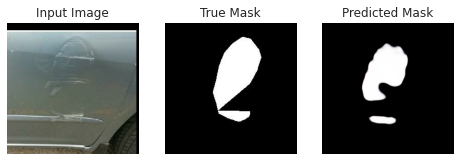


Sample Prediction after epoch 17


Epoch 00017: val_dice_coef did not improve from 0.68061
49/49 [==============================] - 21s 437ms/step - loss: 0.1435 - dice_coef: 0.8565 - val_loss: 0.6491 - val_dice_coef: 0.3509
Epoch 18/50
49/49 [==============================] - ETA: 0s - loss: 0.1454 - dice_coef: 0.8546

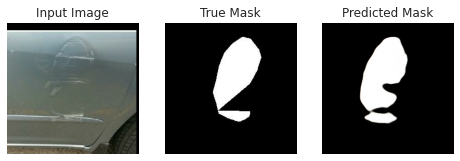


Sample Prediction after epoch 18


Epoch 00018: val_dice_coef improved from 0.68061 to 0.68109, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_simple_unet.h5
49/49 [==============================] - 22s 451ms/step - loss: 0.1454 - dice_coef: 0.8546 - val_loss: 0.3189 - val_dice_coef: 0.6811
Epoch 19/50
49/49 [==============================] - ETA: 0s - loss: 0.1319 - dice_coef: 0.8681

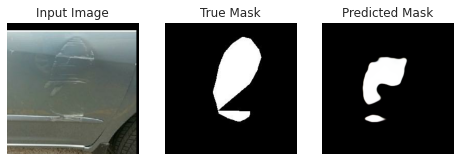


Sample Prediction after epoch 19


Epoch 00019: val_dice_coef did not improve from 0.68109
49/49 [==============================] - 22s 442ms/step - loss: 0.1319 - dice_coef: 0.8681 - val_loss: 0.4239 - val_dice_coef: 0.5761
Epoch 20/50
49/49 [==============================] - ETA: 0s - loss: 0.1520 - dice_coef: 0.8480

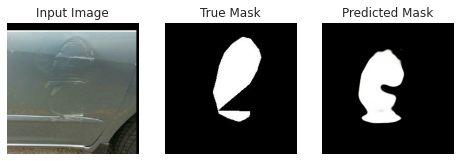


Sample Prediction after epoch 20


Epoch 00020: val_dice_coef did not improve from 0.68109
49/49 [==============================] - 22s 441ms/step - loss: 0.1520 - dice_coef: 0.8480 - val_loss: 0.4744 - val_dice_coef: 0.5256
Epoch 21/50
49/49 [==============================] - ETA: 0s - loss: 0.1249 - dice_coef: 0.8751

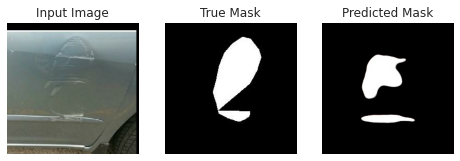


Sample Prediction after epoch 21


Epoch 00021: val_dice_coef did not improve from 0.68109
49/49 [==============================] - 21s 435ms/step - loss: 0.1249 - dice_coef: 0.8751 - val_loss: 0.5635 - val_dice_coef: 0.4365
Epoch 22/50
49/49 [==============================] - ETA: 0s - loss: 0.1384 - dice_coef: 0.8616

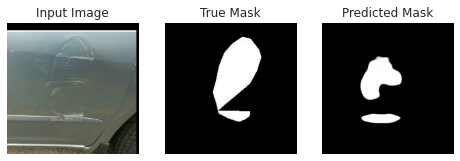


Sample Prediction after epoch 22


Epoch 00022: val_dice_coef did not improve from 0.68109
49/49 [==============================] - 21s 437ms/step - loss: 0.1384 - dice_coef: 0.8616 - val_loss: 0.3225 - val_dice_coef: 0.6775
Epoch 23/50
49/49 [==============================] - ETA: 0s - loss: 0.1325 - dice_coef: 0.8675

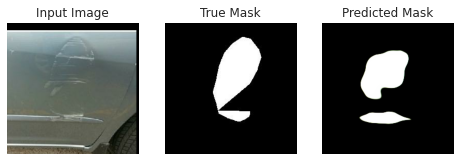


Sample Prediction after epoch 23


Epoch 00023: val_dice_coef did not improve from 0.68109
49/49 [==============================] - 22s 441ms/step - loss: 0.1325 - dice_coef: 0.8675 - val_loss: 0.3624 - val_dice_coef: 0.6376
Epoch 24/50
49/49 [==============================] - ETA: 0s - loss: 0.1197 - dice_coef: 0.8803

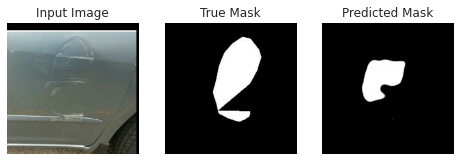


Sample Prediction after epoch 24


Epoch 00024: val_dice_coef did not improve from 0.68109
49/49 [==============================] - 22s 439ms/step - loss: 0.1197 - dice_coef: 0.8803 - val_loss: 0.4076 - val_dice_coef: 0.5924
Epoch 25/50
49/49 [==============================] - ETA: 0s - loss: 0.1078 - dice_coef: 0.8922

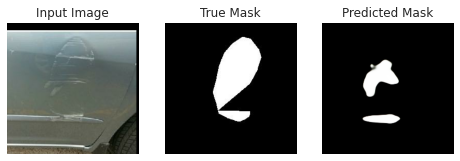


Sample Prediction after epoch 25


Epoch 00025: val_dice_coef improved from 0.68109 to 0.68251, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_simple_unet.h5
49/49 [==============================] - 22s 450ms/step - loss: 0.1078 - dice_coef: 0.8922 - val_loss: 0.3175 - val_dice_coef: 0.6825
Epoch 26/50
49/49 [==============================] - ETA: 0s - loss: 0.1085 - dice_coef: 0.8915

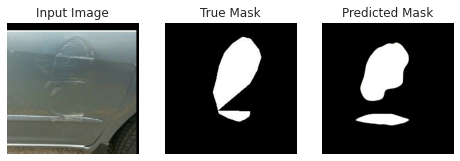


Sample Prediction after epoch 26


Epoch 00026: val_dice_coef improved from 0.68251 to 0.72219, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_simple_unet.h5
49/49 [==============================] - 22s 450ms/step - loss: 0.1085 - dice_coef: 0.8915 - val_loss: 0.2778 - val_dice_coef: 0.7222
Epoch 27/50
49/49 [==============================] - ETA: 0s - loss: 0.1010 - dice_coef: 0.8990

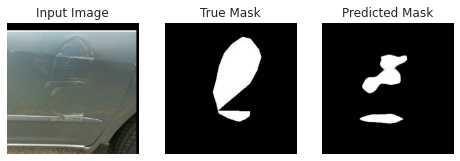


Sample Prediction after epoch 27


Epoch 00027: val_dice_coef did not improve from 0.72219
49/49 [==============================] - 22s 440ms/step - loss: 0.1010 - dice_coef: 0.8990 - val_loss: 0.4328 - val_dice_coef: 0.5672
Epoch 28/50
49/49 [==============================] - ETA: 0s - loss: 0.1171 - dice_coef: 0.8828

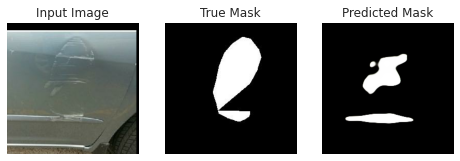


Sample Prediction after epoch 28


Epoch 00028: val_dice_coef did not improve from 0.72219
49/49 [==============================] - 22s 441ms/step - loss: 0.1171 - dice_coef: 0.8828 - val_loss: 0.3819 - val_dice_coef: 0.6181
Epoch 29/50
49/49 [==============================] - ETA: 0s - loss: 0.0969 - dice_coef: 0.9031

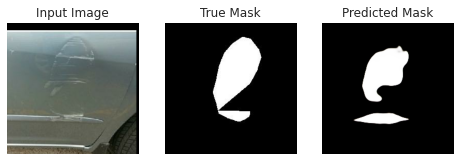


Sample Prediction after epoch 29


Epoch 00029: val_dice_coef did not improve from 0.72219
49/49 [==============================] - 22s 442ms/step - loss: 0.0969 - dice_coef: 0.9031 - val_loss: 0.3384 - val_dice_coef: 0.6616
Epoch 30/50
49/49 [==============================] - ETA: 0s - loss: 0.0925 - dice_coef: 0.9075

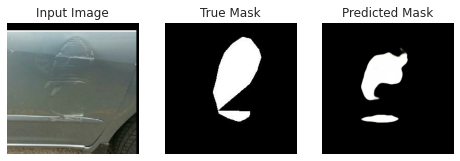


Sample Prediction after epoch 30


Epoch 00030: val_dice_coef did not improve from 0.72219
49/49 [==============================] - 22s 441ms/step - loss: 0.0925 - dice_coef: 0.9075 - val_loss: 0.3319 - val_dice_coef: 0.6681
Epoch 31/50
49/49 [==============================] - ETA: 0s - loss: 0.0923 - dice_coef: 0.9077

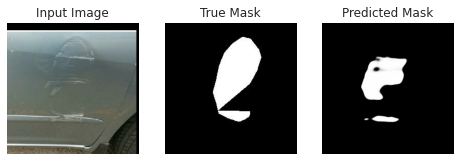


Sample Prediction after epoch 31


Epoch 00031: val_dice_coef did not improve from 0.72219
49/49 [==============================] - 22s 442ms/step - loss: 0.0923 - dice_coef: 0.9077 - val_loss: 0.4042 - val_dice_coef: 0.5958
Epoch 32/50
49/49 [==============================] - ETA: 0s - loss: 0.0834 - dice_coef: 0.9166

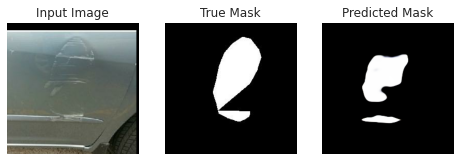


Sample Prediction after epoch 32


Epoch 00032: val_dice_coef did not improve from 0.72219
49/49 [==============================] - 22s 439ms/step - loss: 0.0834 - dice_coef: 0.9166 - val_loss: 0.3484 - val_dice_coef: 0.6516
Epoch 33/50
49/49 [==============================] - ETA: 0s - loss: 0.0891 - dice_coef: 0.9109

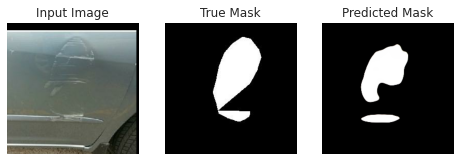


Sample Prediction after epoch 33


Epoch 00033: val_dice_coef did not improve from 0.72219
49/49 [==============================] - 22s 443ms/step - loss: 0.0891 - dice_coef: 0.9109 - val_loss: 0.4200 - val_dice_coef: 0.5800
Epoch 34/50
49/49 [==============================] - ETA: 0s - loss: 0.0826 - dice_coef: 0.9174

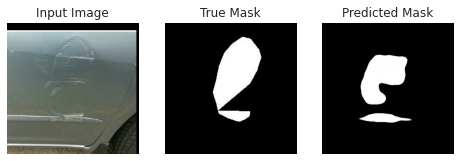


Sample Prediction after epoch 34


Epoch 00034: val_dice_coef did not improve from 0.72219
49/49 [==============================] - 22s 442ms/step - loss: 0.0826 - dice_coef: 0.9174 - val_loss: 0.3623 - val_dice_coef: 0.6377
Epoch 35/50
49/49 [==============================] - ETA: 0s - loss: 0.0827 - dice_coef: 0.9173

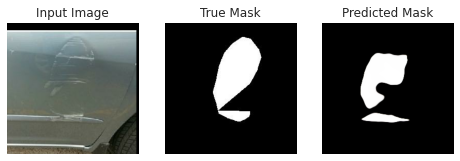


Sample Prediction after epoch 35


Epoch 00035: val_dice_coef did not improve from 0.72219
49/49 [==============================] - 21s 439ms/step - loss: 0.0827 - dice_coef: 0.9173 - val_loss: 0.3324 - val_dice_coef: 0.6676
Epoch 36/50
49/49 [==============================] - ETA: 0s - loss: 0.0777 - dice_coef: 0.9223

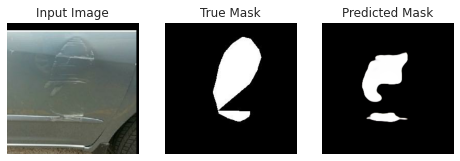


Sample Prediction after epoch 36


Epoch 00036: val_dice_coef did not improve from 0.72219
49/49 [==============================] - 22s 439ms/step - loss: 0.0777 - dice_coef: 0.9223 - val_loss: 0.3212 - val_dice_coef: 0.6788
Epoch 37/50
49/49 [==============================] - ETA: 0s - loss: 0.0746 - dice_coef: 0.9253

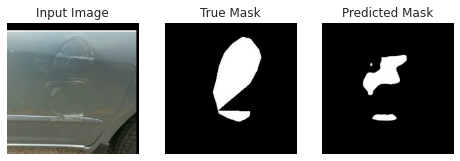


Sample Prediction after epoch 37


Epoch 00037: val_dice_coef did not improve from 0.72219
49/49 [==============================] - 22s 441ms/step - loss: 0.0746 - dice_coef: 0.9253 - val_loss: 0.4991 - val_dice_coef: 0.5009
Epoch 38/50
49/49 [==============================] - ETA: 0s - loss: 0.0789 - dice_coef: 0.9211

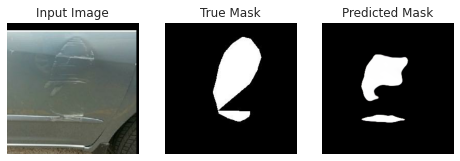


Sample Prediction after epoch 38


Epoch 00038: val_dice_coef did not improve from 0.72219
49/49 [==============================] - 22s 442ms/step - loss: 0.0789 - dice_coef: 0.9211 - val_loss: 0.3097 - val_dice_coef: 0.6903
Epoch 39/50
49/49 [==============================] - ETA: 0s - loss: 0.0789 - dice_coef: 0.9210

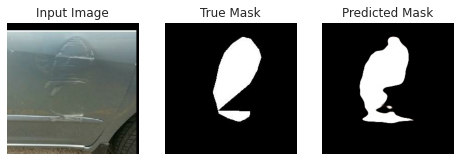


Sample Prediction after epoch 39


Epoch 00039: val_dice_coef did not improve from 0.72219
49/49 [==============================] - 22s 444ms/step - loss: 0.0789 - dice_coef: 0.9210 - val_loss: 0.3645 - val_dice_coef: 0.6355
Epoch 40/50
49/49 [==============================] - ETA: 0s - loss: 0.0695 - dice_coef: 0.9305

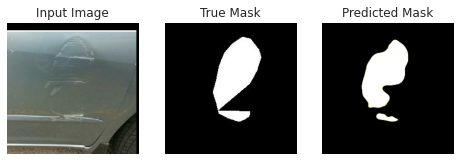


Sample Prediction after epoch 40


Epoch 00040: val_dice_coef did not improve from 0.72219
49/49 [==============================] - 22s 440ms/step - loss: 0.0695 - dice_coef: 0.9305 - val_loss: 0.5104 - val_dice_coef: 0.4896
Epoch 41/50
49/49 [==============================] - ETA: 0s - loss: 0.0696 - dice_coef: 0.9304

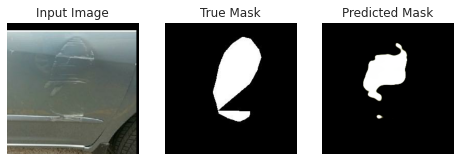


Sample Prediction after epoch 41


Epoch 00041: val_dice_coef did not improve from 0.72219
49/49 [==============================] - 21s 437ms/step - loss: 0.0696 - dice_coef: 0.9304 - val_loss: 0.5546 - val_dice_coef: 0.4454
Epoch 42/50
49/49 [==============================] - ETA: 0s - loss: 0.0666 - dice_coef: 0.9334

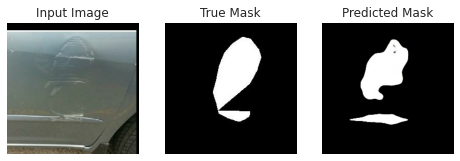


Sample Prediction after epoch 42


Epoch 00042: val_dice_coef improved from 0.72219 to 0.73359, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_simple_unet.h5
49/49 [==============================] - 22s 445ms/step - loss: 0.0666 - dice_coef: 0.9334 - val_loss: 0.2664 - val_dice_coef: 0.7336
Epoch 43/50
49/49 [==============================] - ETA: 0s - loss: 0.0669 - dice_coef: 0.9331

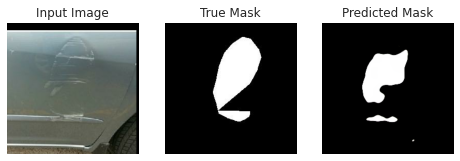


Sample Prediction after epoch 43


Epoch 00043: val_dice_coef did not improve from 0.73359
49/49 [==============================] - 21s 438ms/step - loss: 0.0669 - dice_coef: 0.9331 - val_loss: 0.4091 - val_dice_coef: 0.5909
Epoch 44/50
49/49 [==============================] - ETA: 0s - loss: 0.0595 - dice_coef: 0.9405

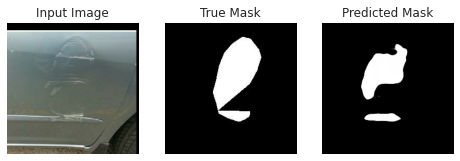


Sample Prediction after epoch 44


Epoch 00044: val_dice_coef did not improve from 0.73359
49/49 [==============================] - 22s 439ms/step - loss: 0.0595 - dice_coef: 0.9405 - val_loss: 0.3969 - val_dice_coef: 0.6031
Epoch 45/50
49/49 [==============================] - ETA: 0s - loss: 0.0579 - dice_coef: 0.9421

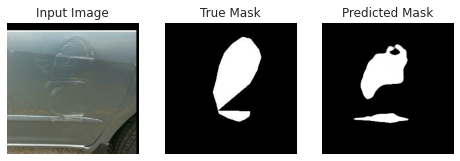


Sample Prediction after epoch 45


Epoch 00045: val_dice_coef did not improve from 0.73359
49/49 [==============================] - 22s 439ms/step - loss: 0.0579 - dice_coef: 0.9421 - val_loss: 0.2827 - val_dice_coef: 0.7173
Epoch 46/50
49/49 [==============================] - ETA: 0s - loss: 0.0707 - dice_coef: 0.9293

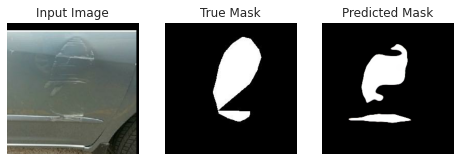


Sample Prediction after epoch 46


Epoch 00046: val_dice_coef did not improve from 0.73359
49/49 [==============================] - 22s 439ms/step - loss: 0.0707 - dice_coef: 0.9293 - val_loss: 0.3025 - val_dice_coef: 0.6975
Epoch 47/50
49/49 [==============================] - ETA: 0s - loss: 0.0691 - dice_coef: 0.9309

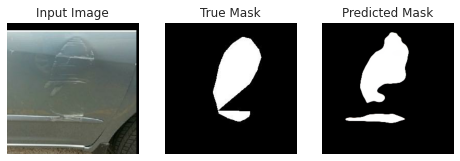


Sample Prediction after epoch 47


Epoch 00047: val_dice_coef did not improve from 0.73359
49/49 [==============================] - 22s 439ms/step - loss: 0.0691 - dice_coef: 0.9309 - val_loss: 0.4344 - val_dice_coef: 0.5656
Epoch 48/50
49/49 [==============================] - ETA: 0s - loss: 0.0560 - dice_coef: 0.9440

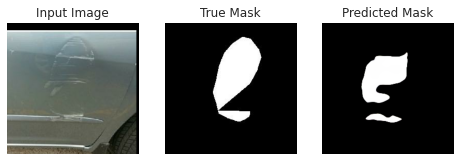


Sample Prediction after epoch 48


Epoch 00048: val_dice_coef did not improve from 0.73359
49/49 [==============================] - 22s 439ms/step - loss: 0.0560 - dice_coef: 0.9440 - val_loss: 0.4839 - val_dice_coef: 0.5161
Epoch 49/50
49/49 [==============================] - ETA: 0s - loss: 0.0652 - dice_coef: 0.9348

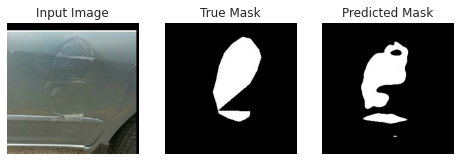


Sample Prediction after epoch 49


Epoch 00049: val_dice_coef did not improve from 0.73359
49/49 [==============================] - 22s 444ms/step - loss: 0.0652 - dice_coef: 0.9348 - val_loss: 0.3449 - val_dice_coef: 0.6551
Epoch 50/50
49/49 [==============================] - ETA: 0s - loss: 0.0639 - dice_coef: 0.9361

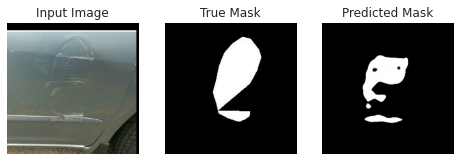


Sample Prediction after epoch 50


Epoch 00050: val_dice_coef did not improve from 0.73359
49/49 [==============================] - 21s 439ms/step - loss: 0.0639 - dice_coef: 0.9361 - val_loss: 0.3538 - val_dice_coef: 0.6462


In [299]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 5//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit_generator(tf_image_generator, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_tf_image_generator,
                          callbacks=[DisplayCallback(), mc, tensorboard])

### Plotting Losses

### TensorBoard

<img src="images/tensorboard_unet_simple.PNG">

Sample predictions



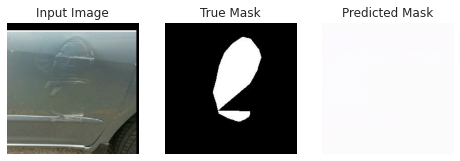

In [303]:
# Loading best model
model = Nested_UNet(OUTPUT_CHANNELS)
model.compile(optimizer=optimizer, loss=sm.losses.dice_loss, metrics=[dice_coef])
print('Sample predictions\n')
show_predictions()
model.load_weights('/content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_simple_unet.h5')

In [304]:
# Save the entire model as a SavedModel.
model.save('/content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_simple_unet')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_simple_unet/assets


In [0]:
model = load_model('/content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_simple_unet', custom_objects=dependencies)

## 6. Predictions

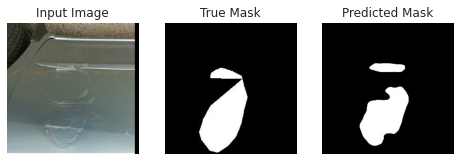

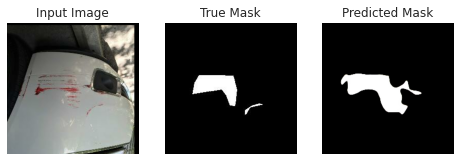

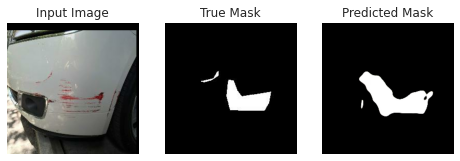

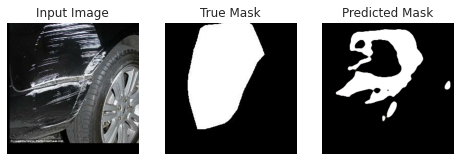

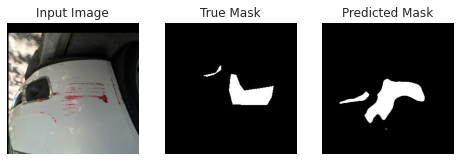

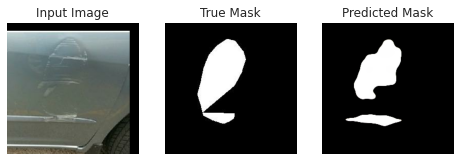

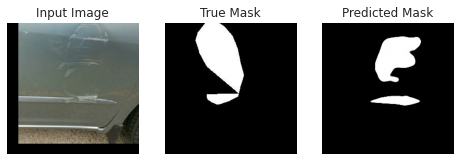

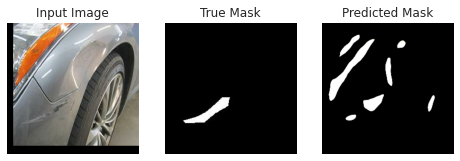

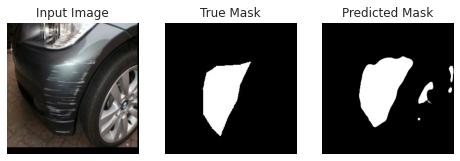

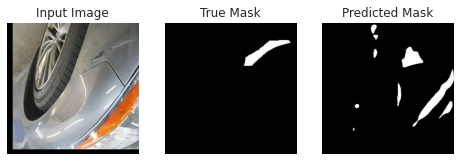

In [306]:
for image, mask in val_tf_image_generator.take(10):
  sample_image, sample_mask = image[0], mask[0]
  display1([sample_image, sample_mask,
         model.predict(sample_image[tf.newaxis, ...])[0]])